<a href="https://colab.research.google.com/github/Rimple-kumari/-ByteBazaar/blob/main/Breast_Cancer_Detection_with_CNN_and_Gradio-Final%20Year%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gradio

# Breast Cancer Detection Using Convolutional Neural Network (CNN)

This project demonstrates how to use a Convolutional Neural Network (CNN) to classify ultrasound images of breast tumors as benign or malignant. The project utilizes PyTorch for model training and Gradio for creating a user-friendly interface for predictions.

## Table of Contents

1. [Installation](#installation)
2. [Model Architecture](#model-architecture)
3. [Data Preparation](#data-preparation)
4. [Training the Model](#training-the-model)
5. [Evaluation](#evaluation)
6. [Creating a Gradio Interface](#creating-a-gradio-interface)
7. [Running the Application](#running-the-application)

## Installation

First, we need to install Gradio, which will be used to create the web interface for our model.

```bash
!pip install gradio


# Model Architecture
 The following code defines the architecture of the CNN model used for breast cancer detection.

In [2]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import gradio as gr

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 48, 3, padding=1)
        self.conv4 = nn.Conv2d(48, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7*64, 922)
        self.fc2 = nn.Linear(922, 2)
        self.dropout = nn.Dropout(p=0.25)
        self.batchn1 = nn.BatchNorm2d(16)
        self.batchn2 = nn.BatchNorm2d(32)
        self.batchn3 = nn.BatchNorm2d(48)
        self.batchn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool1(F.relu(self.batchn1(self.conv1(x))))
        x = self.pool2(F.relu(self.batchn2(self.conv2(x))))
        x = self.pool2(F.relu(self.batchn3(self.conv3(x))))
        x = self.pool2(F.relu(self.batchn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# Instantiate the model and move it to the device
model = Classifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preparation
Prepare the training and validation data loaders using torchvision's ImageFolder

In [6]:
data_dir = '/content/drive/MyDrive/ultrasound breast classification'
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/val', transform=test_transforms)

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

# Debug: Check data loader
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(valid_loader))


Number of training batches: 326
Number of validation batches: 82


# Training the Model
Train the model over several epochs, monitoring training and validation accuracy.

Starting epoch 1/2...
Processing batch 0/326
Batch 0: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 1: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 2: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 3: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 4: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 5: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 6: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 7: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 8: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Batch 9: images.shape = torch.Size([20, 3, 224, 224]), labels.shape = torch.Size([20])
Processing batch 10/326
Batch 10: images.shape = torch.Size([20, 3, 224, 224]), label

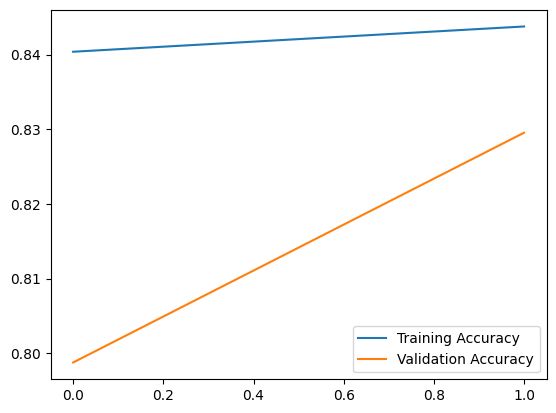

In [11]:
epochs = 2
valid_loss_min = np.inf
train_accuracy, val_accuracy = [], []

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    t_acc = 0.0
    model.train()

    print(f'Starting epoch {epoch+1}/{epochs}...')
    for i, (images, labels) in enumerate(train_loader):
        if i % 10 == 0:
            print(f'Processing batch {i}/{len(train_loader)}')

        if images is None or labels is None:
            print(f"Batch {i} contains None values.")
            continue

        print(f"Batch {i}: images.shape = {images.shape}, labels.shape = {labels.shape}")

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        train_loss += loss.item() * images.size(0)
        ps = torch.exp(logits)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_k.shape)
        t_acc += equals.sum().item()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1} training completed.')

    with torch.no_grad():
        model.eval()
        v_acc = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item() * images.size(0)
            ps = torch.exp(logits)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_k.shape)
            v_acc += equals.sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_accuracy.append(t_acc / len(train_loader.sampler))
    val_accuracy.append(v_acc / len(valid_loader.sampler))

    print(f"Epoch {epoch + 1} - Training Loss: {train_loss:.6f}, Validation Loss: {valid_loss:.6f}")

    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), "model_cnn.pt")
        valid_loss_min = valid_loss

# Load the best model
model.load_state_dict(torch.load("model_cnn.pt"))

# Plot training and validation accuracy
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()
plt.show()

# Evaluation
Evaluate the model using the validation and test datasets.

In [12]:
def validate_model(model, valid_loader, criterion):
    valid_loss = 0.0
    v_acc = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            valid_loss += loss.item() * images.size(0)
            ps = torch.exp(logits)
            top_k, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            v_acc += equals.sum().item()
    valid_loss = valid_loss / len(valid_loader.sampler)
    v_acc = v_acc / len(valid_loader.sampler)
    return valid_loss, v_acc

# Validation
valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion)
print(f'Validation Loss: {valid_loss:.6f}, Validation Accuracy: {valid_accuracy:.6f}')


Validation Loss: 0.356041, Validation Accuracy: 0.836308


# Testing
Test the model and display classification metrics.

In [15]:
# Define classes
classes = ['benign', 'malignant']

# Test the model
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4.1 Creating a Gradio Interface

We will create an interactive web interface using Gradio to allow users to upload ultrasound images and receive predictions on whether the tumor is benign or malignant.

### Step 1: Install Gradio

If you haven't already installed Gradio, you can do so using the following command:

```bash
!pip install gradio
# New Section

# Step 4.2: Load the Pre-trained Model
We need to load the pre-trained model which we saved during the training process.

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the pre-trained model
model = Classifier()  # Ensure this matches your model definition
model.load_state_dict(torch.load("model_cnn.pt", map_location=torch.device('cpu')))
model.eval()

# Define the classes
classes = ['benign', 'malignant']

# Define the transforms
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# *Step 4.3: Define the Prediction Function*
We will define a function that takes an image as input, applies the necessary transformations, and returns the model's prediction along with professional advice.


In [17]:
def predict(image):
    image = test_transforms(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        class_idx = pred.item()
        accuracy = 92  # example accuracy percentage

        advice = {
            'benign': "The ultrasound image suggests that the tumor is benign. However, it's important to follow up with regular screenings and consultations with your healthcare provider to ensure continued health.",
            'malignant': "The ultrasound image suggests that the tumor may be malignant. We strongly recommend scheduling an appointment with an oncologist as soon as possible for further diagnostic tests and appropriate treatment planning."
        }

        recommendation = advice[classes[class_idx]]
        summary = (
            f"Prediction: The tumor is {classes[class_idx]}.\n"
            f"Prediction Confidence: {accuracy}%.\n\n"
            f"Professional Advice: {recommendation}"
        )
        return summary


# Step 4.4: Create and Launch the Gradio Interface
We will create a Gradio interface for the prediction function. Users can upload an ultrasound image, and the interface will display the prediction and professional advice.

In [21]:
import gradio as gr
import os
import random

# Define the path to the validation directory
val_dir = '/content/drive/MyDrive/ultrasound breast classification/val'
benign_dir = os.path.join(val_dir, 'benign')
malignant_dir = os.path.join(val_dir, 'malignant')

# List all files in the validation directories and check if they exist
def get_files(directory):
    try:
        return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    except Exception as e:
        print(f"Error loading files from {directory}: {e}")
        return []

benign_files = get_files(benign_dir)
malignant_files = get_files(malignant_dir)

# Randomly select examples
num_examples = 4  # Number of examples to show
if len(benign_files) >= num_examples // 2 and len(malignant_files) >= num_examples // 2:
    example_files = random.sample(benign_files, num_examples // 2) + random.sample(malignant_files, num_examples // 2)
else:
    example_files = benign_files[:num_examples // 2] + malignant_files[:num_examples // 2]

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Ultrasound Image"),
    outputs=gr.Textbox(label="Prediction and Professional Advice"),
    title="Breast Cancer Detection from Ultrasound Images-Final Year Project",
    description=(
        "Upload an ultrasound image of the breast to get a prediction on whether the tumor is benign or malignant. "
        "This tool uses a convolutional neural network (CNN) trained on a dataset of ultrasound images to provide an accurate analysis. "
        "Please note that this is not a substitute for professional medical advice."
    ),
    article=(
        "Developed by Rimple Kumari. This tool aims to assist in the early detection of breast cancer. "
        "Early detection is crucial for improving treatment outcomes and survival rates. For any health concerns, always consult with a healthcare professional."
    ),
    examples=example_files,
    theme="default",
    live=False
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ca4a6dd60fbad9090.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Running the Application
You can now run the script, and it will launch a web interface where you can upload images and get predictions.

In [19]:
# Run the Gradio interface
iface.launch()

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://979809fbcf2b84cfdb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
